# Analyse du risque de défaillance des joints toriques de la navette Challenger

Le 27 Janvier 1986, veille du décollage de la navette *Challenger*, eu
lieu une télé-conférence de trois heures entre les ingénieurs de la
Morton Thiokol (constructeur d'un des moteurs) et de la NASA. La
discussion portait principalement sur les conséquences de la
température prévue au moment du décollage de 31°F (juste en dessous de
0°C) sur le succès du vol et en particulier sur la performance des
joints toriques utilisés dans les moteurs. En effet, aucun test
n'avait été effectué à cette température.

L'étude qui suit reprend donc une partie des analyses effectuées cette
nuit là et dont l'objectif était d'évaluer l'influence potentielle de
la température et de la pression à laquelle sont soumis les joints
toriques sur leur probabilité de dysfonctionnement. Pour cela, nous
disposons des résultats des expériences réalisées par les ingénieurs
de la NASA durant les 6 années précédant le lancement de la navette
Challenger.



## Chargement des données
Nous commençons donc par charger ces données:

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv("shuttle.csv")
data

,Date,Count,Temperature,Pressure,Malfunction
0,4/12/81,6,66,50,0
1,11/12/81,6,70,50,1
2,3/22/82,6,69,50,0
3,11/11/82,6,68,50,0
4,4/04/83,6,67,50,0
5,6/18/82,6,72,50,0
6,8/30/83,6,73,100,0
7,11/28/83,6,70,100,0
8,2/03/84,6,57,200,1
9,4/06/84,6,63,200,1


Le jeu de données nous indique la date de l'essai, le nombre de joints
toriques mesurés (il y en a 6 sur le lançeur principal), la
température (en Farenheit) et la pression (en psi), et enfin le
nombre de dysfonctionnements relevés. 

## Inspection graphique des données
Les vols où aucun incident n'est relevé n'apportant aucun information
sur l'influence de la température ou de la pression sur les
dysfonctionnements, nous nous concentrons sur les expériences où au
moins un joint a été défectueux.


In [2]:
data = data[data.Malfunction>0]
data

,Date,Count,Temperature,Pressure,Malfunction
1,11/12/81,6,70,50,1
8,2/03/84,6,57,200,1
9,4/06/84,6,63,200,1
10,8/30/84,6,70,200,1
13,1/24/85,6,53,200,2
20,10/30/85,6,75,200,2
22,1/12/86,6,58,200,1


Très bien, nous avons une variabilité de température importante mais
la pression est quasiment toujours égale à 200, ce qui devrait
simplifier l'analyse.

Comment la fréquence d'échecs varie-t-elle avec la température ?


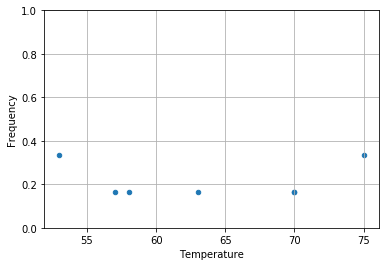

In [3]:
%matplotlib inline
pd.set_option('mode.chained_assignment',None) # this removes a useless warning from pandas
import matplotlib.pyplot as plt

data["Frequency"]=data.Malfunction/data.Count
data.plot(x="Temperature",y="Frequency",kind="scatter",ylim=[0,1])
plt.grid(True)

À première vue, ce n'est pas flagrant mais bon, essayons quand même
d'estimer l'impact de la température $t$ sur la probabilité de
dysfonctionnements d'un joint. 


## Estimation de l'influence de la température

Supposons que chacun des 6 joints toriques est endommagé avec la même
probabilité et indépendamment des autres et que cette probabilité ne
dépend que de la température. Si on note $p(t)$ cette probabilité, le
nombre de joints $D$ dysfonctionnant lorsque l'on effectue le vol à
température $t$ suit une loi binomiale de paramètre $n=6$ et
$p=p(t)$. Pour relier $p(t)$ à $t$, on va donc effectuer une
régression logistique.

In [4]:
import statsmodels.api as sm

data["Success"]=data.Count-data.Malfunction
data["Intercept"]=1

logmodel=sm.GLM(data['Frequency'], data[['Intercept','Temperature']], family=sm.families.Binomial(sm.families.links.logit)).fit()

logmodel.summary()

/usr/lib/python3/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                    7
Model:                            GLM   Df Residuals:                        5
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -3.6370
Date:                Fri, 20 Jul 2018   Deviance:                       3.3763
Time:                        17:09:09   Pearson chi2:                    0.236
No. Iterations:                     5                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.3895      7.828     -0.178      0.859     -16.732      13.953
Temperature     0.0014      0.122      0.012      0.991      -0.238       0.240
===============================================================================
"""

L'estimateur le plus probable du paramètre de température est 0.0014
et l'erreur standard de cet estimateur est de 0.122, autrement dit on
ne peut pas distinguer d'impact particulier et il faut prendre nos
estimations avec des pincettes.


## Estimation de la probabilité de dysfonctionnant des joints toriques
La température prévue le jour du décollage est de 31°F. Essayons
d'estimer la probabilité de dysfonctionnement des joints toriques à
cette température à partir du modèle que nous venons de construire:


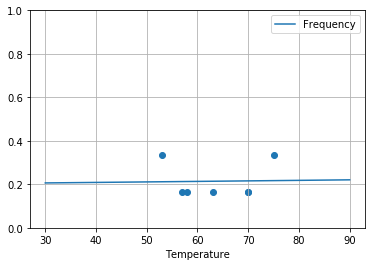

In [5]:
%matplotlib inline
data_pred = pd.DataFrame({'Temperature': np.linspace(start=30, stop=90, num=121), 'Intercept': 1})
data_pred['Frequency'] = logmodel.predict(data_pred)
data_pred.plot(x="Temperature",y="Frequency",kind="line",ylim=[0,1])
plt.scatter(x=data["Temperature"],y=data["Frequency"])
plt.grid(True)

Comme on pouvait s'attendre au vu des données initiales, la
température n'a pas d'impact notable sur la probabilité d'échec des
joints toriques. Elle sera d'environ 0.2, comme dans les essais
précédents où nous il y a eu défaillance d'au moins un joint. Revenons
à l'ensemble des données initiales pour estimer la probabilité de
défaillance d'un joint:


In [6]:
data = pd.read_csv("shuttle.csv")
print(np.sum(data.Malfunction)/np.sum(data.Count))

0.06521739130434782


Cette probabilité est donc d'environ $p=0.065$, sachant qu'il existe
un joint primaire un joint secondaire sur chacune des trois parties du
lançeur, la probabilité de défaillance des deux joints d'un lançeur
est de $p^2 \approx 0.00425$. La probabilité de défaillance d'un des
lançeur est donc de $1-(1-p^2)^3 \approx 1.2%$.  Ça serait vraiment
pas de chance... Tout est sous contrôle, le décollage peut donc avoir
lieu demain comme prévu.

Seulement, le lendemain, la navette Challenger explosera et emportera
avec elle ses sept membres d'équipages. L'opinion publique est
fortement touchée et lors de l'enquête qui suivra, la fiabilité des
joints toriques sera directement mise en cause. Au delà des problèmes
de communication interne à la NASA qui sont pour beaucoup dans ce
fiasco, l'analyse précédente comporte (au moins) un petit
problème... Saurez-vous le trouver ? Vous êtes libre de modifier cette
analyse et de regarder ce jeu de données sous tous les angles afin
d'expliquer ce qui ne va pas.